In [2]:
# ########################### 70 Characters ##########################

In [3]:
"""
This Python file solve optimal transport problem using interior point
method and simplex method by calling Mosek. The input data will be
given randomly. After executing this Python file, it will generate
two log files (logs for each method), and two txt files (solutions
through each method).
"""
%matplotlib notebook
from mosek import *
import numpy.random as rdm
import numpy as np
import math
import copy
from time import time
from tqdm import *
import networkx as nx
from numba import jitclass, jit
from numba import int32, int64, float32
import matplotlib.pyplot as plt

In [4]:
@jit
def distance(n):
    """Returns the Euclidean distance matrix between pixels in two images,
    exactly a :math:`n^2 \times n^2` matrix.

    Arguments:
        n: An integer to tells the size of the image.
    """
    
    dmatrix = np.zeros([n * n, n * n])

    # TODO: perform optimization here
    
    for i1 in range(n):
        for j1 in range(n):
            for i2 in range(n):
                for j2 in range(n):
                    dmatrix[i1 * n + i2, j1 * n + j2] = math.sqrt(
                          (j1 - i1) ** 2
                        + (j2 - i2) ** 2
                    )

    return dmatrix

In [5]:
class StreamBuffer():
    """A class to buffer strings from a stream.
    
    Arguments:
        explicit_echo: A boolean to indicate whether explicit
        echo, namely outputs to stdout, should be sent.
    """
    
    def __init__(self, explicit_echo=False):
        self.buffer = ""
        self.explicit_echo = explicit_echo
    
    def streamprinter(self, text):
        """A virtual stream printer derived from the buffer.
        
        Arguments:
            text: Some messages in the stream, which is added
                to the buffer.
        """
        self.buffer += text
        if (self.explicit_echo):
            print(text, end="")

In [6]:
def calculate(m, n, c, mu, nu, opttype, printer):
    """Perform optimization by calling mosek.
    
    Arguments:
        opttype: Indicator to the optimization method, should be
            ``optimizertype.intpnt`` or ``optimizertype.free_simplex``.
        printer (function): A function to handle logs to be printed.
    """
    
    # TODO: Add necessary information about arguments
    with Env() as env:
        with env.Task(0,0) as task:
            task.putintparam(iparam.optimizer, opttype)
            task.set_Stream(streamtype.log, printer)
            
            bkc = [boundkey.fx] * (m + n)
            bkx = [boundkey.lo] * m * n
            blc = [i for i in mu] + [i for i in nu]
            buc = [i for i in mu] + [i for i in nu]
            blx = [0] * m * n
            bux = [0.0] * m * n
            asub = [[int(i / n), m + (i % n)] for i in range(m * n)]
            aval = [[1, 1] for i in range(m * n)]
            numvar = len(bkx)
            numcon = len(bkc)
            
            task.appendvars(numvar)
            task.appendcons(numcon)
            
            for j in range(numvar):
                task.putcj(j, c[j])
                task.putvarbound(j, bkx[j], blx[j], bux[j])
                task.putacol(j, asub[j], aval[j])
                
            for i in range(numcon):
                task.putconbound(i, bkc[i], blc[i], buc[i])
                
            task.putobjsense(objsense.minimize)
            
            task.optimize()
            
            task.solutionsummary(streamtype.msg)
            xx = [0.] * numvar            
            task.getxx(soltype.bas, xx)
            
            return xx

In [7]:
spec = {'m':int32, 'n':int32, 'mu':float32[:], 'nu':float32[:]}

In [8]:
class OT:
    def __init__(self, m, n, mu, nu, dist):
        """
        Initialize an optimal transport problem.
        """
        self.m = m
        self.n = n
        self.mu = mu
        self.nu = nu
        self.dist = dist
        self.g = nx.Graph()
        a = [i for i in range(1, m+1)]
        b = [-i for i in range(1, n+1)]
        self.g.add_nodes_from(a, bipartite=0)
        self.g.add_nodes_from(b, bipartite=1)
        self.mu_dual = {}
        self.nu_dual = {}
        self.p_value = []
        self.value = 0
        self.iter = 0
    
    def find_solution(self):
        """
        Find a basis solution.
        """
        j = 0
        nu1 = copy.deepcopy(self.nu)
        
        for i in range(m):
            tmp = self.mu[i]
            
            while j < n:
                if nu1[j] >= tmp:
                    nu1[j] = nu1[j] - tmp
                    self.g.add_edge(i+1, -j-1, weight=tmp)
                    tmp = 0
                    if nu1[j] == tmp and i < m-1:
                        self.g.add_edge(i+2, -j-1, weight=0)
                        j = j + 1
                    break
                else:
                    self.g.add_edge(i+1, -j-1, weight=nu1[j])
                    tmp = tmp - nu1[j]
                    nu1[j] = 0
                    j = j + 1
              
            
    def primal_value(self):
        """
        Calculate the primal value with respect to the solution.
        """
        sum = 0
        for x,y in self.g.edges:
            sum = sum + self.g.edges[x, y]['weight'] * self.dist[abs(x)-1, abs(y)-1]
        return sum
        
    
    def draw_graph(self):
        """
        Draw an explicit graph of the graph
        """
        x, y = bipartite.sets(self.g)
        pos = dict()
        pos.update((u, (1, i)) for i, u in enumerate(x))
        pos.update((u, (2, i)) for i, u in enumerate(y))
        nx.draw(self.g, pos, with_labels=True)
    
    
    def find_dual(self):
        """
        Find the dual variables according to the primal variables.
        """
        self.mu_dual[1] = 0
        queue = [1]
        father = {1:1}
        u = 0
        
        while len(queue) < self.m + self.n:
            if u >= len(queue):
                break
            i = queue[u]
            u = u + 1
            dic = self.g.neighbors(i)
            
            for item in dic:
                if item not in father.keys():
                    queue.append(item)
                    father[item] = i
                    if item > 0:
                        self.mu_dual[item] = self.dist[item-1, abs(i)-1] - self.nu_dual[i]
                    else:
                        self.nu_dual[item] = self.dist[i-1, abs(item)-1] - self.mu_dual[i]
         
        mu_dual1 = np.array([self.mu_dual[i+1] for i in range(m)]).reshape(1, m)
        nu_dual1 = np.array([self.nu_dual[-i-1] for i in range(n)]).reshape(n, 1)
        self.c_dual = copy.deepcopy(self.dist).T
        self.c_dual = self.c_dual - mu_dual1 - nu_dual1
    
    
    def find_loop(self, u, v):
        """
        Find a loop in the graph after adding the edge u--v
        """
        set1 = [v]
        visit= {v:0}
        flag = 0
        w = 0
        
        while(True):
            now = set1[w]
            w = w + 1
            for i in self.g.neighbors(now):
                if i not in visit:
                    set1.append(i)
                    visit[i] = now
                if i == u:
                    flag = 1
                    break
            if flag == 1:
                break
                
        l = []
        t = u
        
        while t != v:
            l.append((t, visit[t]))
            t = visit[t]
        l.append((v, u))
        
        return l
    
    
    def update(self, u, v):
        """
        Update the graph after adding the edge u--v.
        """
        loop = self.find_loop(u, v)
        self.g.add_edge(u, v, weight=0)
        min1 = float('inf')
        dis1 = sum([self.dist[i-1, abs(j)-1] for i,j in loop if i > 0])
        dis2 = sum([self.dist[j-1, abs(i)-1] for i,j in loop if i < 0])
        
        for i,j in loop:
            if i > 0:
                if min1 > self.g.edges[i, j]['weight']:
                    min1 = self.g.edges[i, j]['weight']
                    x1, y1 = i, j
                    
        if dis1 <= dis2:
            self.g.remove_edge(u, v)
        else:
            for i,j in loop:
                if i > 0:
                    self.g.edges[i, j]['weight'] -= min1
                else:
                    self.g.edges[i, j]['weight'] += min1
            self.g.remove_edge(x1, y1)
    
    
    def transportation_simplex(self, epsilon=1e-12):
        """
        Running transportation simplex method.
        
        Arguments:
            epsilon: representing the error bound according to the machine precision.
        """
        self.find_solution()
        while True:
            self.iter = self.iter + 1
            if self.iter%100 == 0:
                print(self.iter, end=" ")
            
            self.find_dual()
            t = np.where(self.c_dual == np.min(self.c_dual))
            u, v = t[0][0], t[1][0]
            
            self.value = self.primal_value()
            self.p_value.append(self.value)
            
            if self.c_dual[u, v] >= -epsilon:
                break
                
            self.update(v+1, -u-1)
        print("finish", tt.iter)
    
    
    def export_solution(self):
        """
        Export the solution in a numpy array.
        """
        arr = np.zeros([self.m, self.n])
        for u, v in self.g.edges:
            arr[u-1, -v-1] = self.g.edges[u, v]['weight']
        return arr
    

In [20]:
def routine(t, method, explicit_echo=False):
    """Using an given method to solve OT.
    
    Arguments:
        t: An integer indicate the size of the image.
        method: An given method, should be ``optimizertype.intpnt``
        or ``optimizertype.free_simplex``.
    """
    
    m = t ** 2
    n = t ** 2
    c1 = distance(t)
    c = c1.reshape(m * n)
    
    # Generate random value for mu, nu (mu, nu represent pixel values in each images)
    total = 10000
    mu1 = rdm.rand(m)
    nu1 = rdm.rand(n)
    mu = [i * total / sum(mu1) for i in mu1]
    nu = [i * total / sum(nu1) for i in nu1]
    
    log = StreamBuffer(explicit_echo)
    xx = calculate(m, n, c, mu, nu, method, log.streamprinter)
    
    return {"xx": xx, "log": log.buffer}

In [9]:
explicit_echo=True
method = optimizertype.free_simplex
m = 400
n = 400
start = time()
dist = distance(20)
stop = time()
print(stop-start)
total = 10000
mu1 = rdm.rand(m)
nu1 = rdm.rand(n)
mu = [i * total / sum(mu1) for i in mu1]
nu = [i * total / sum(nu1) for i in nu1]
log = StreamBuffer(explicit_echo)

xx = calculate(m, n, dist.reshape(m*n), mu, nu, method, log.streamprinter)
tt = OT(m, n, mu, nu, dist)

start = time()
tt.transportation_simplex()
stop = time()

print(tt.value)
print(stop-start)

0.3016808032989502
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 800             
  Cones                  : 0               
  Scalar variables       : 160000          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Simplex optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.10    
Primal simplex optimizer started.
Primal simplex optimizer setup started.
Primal simplex optimizer setup terminated.
Optimizer  - solved problem         : the primal      
Optimize

In [15]:
mat = tt.export_solution()

<IPython.core.display.Javascript object>


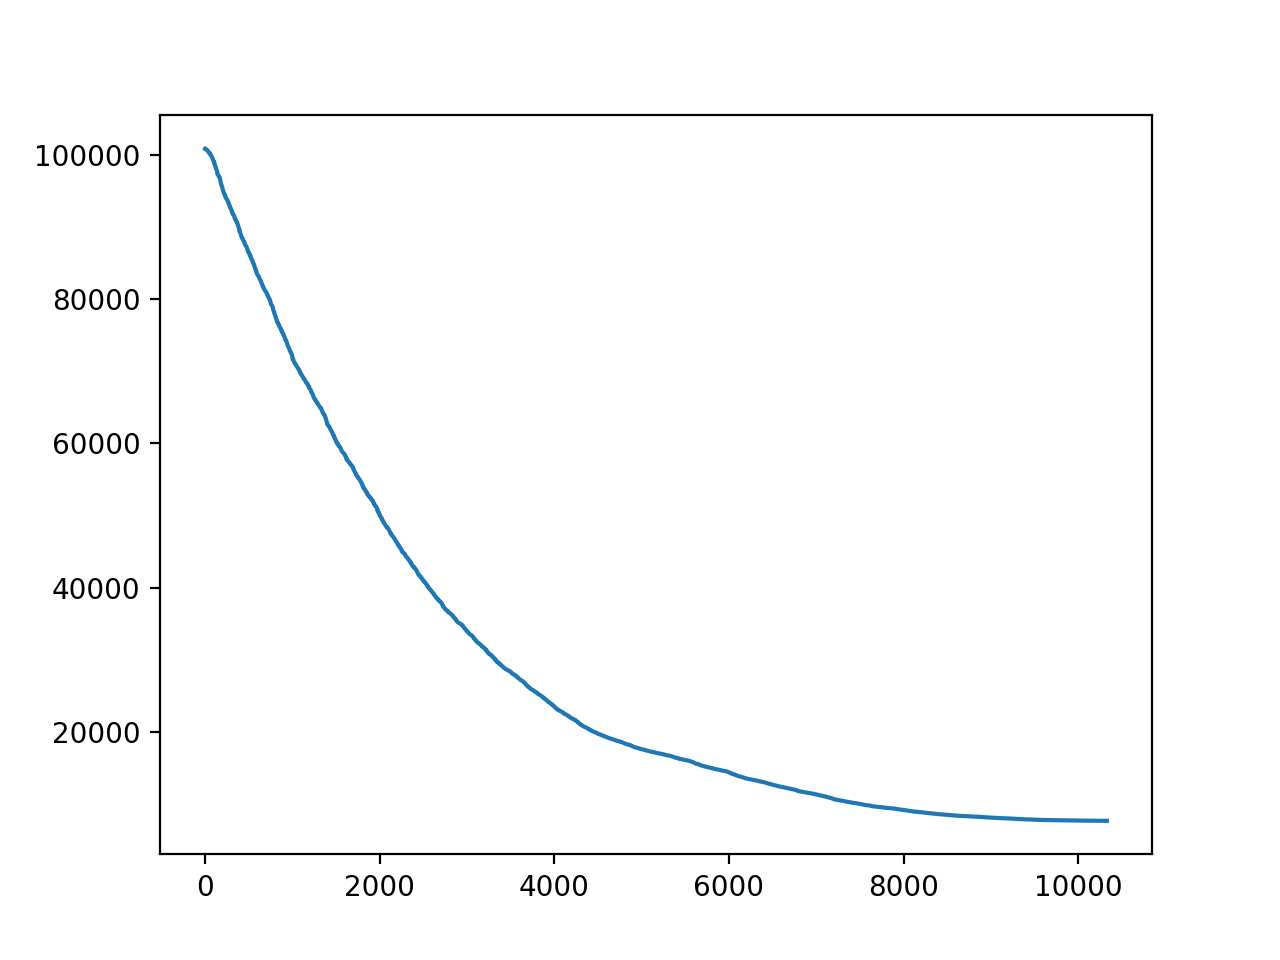

In [18]:
plt.plot(np.linspace(1, tt.iter, tt.iter), tt.p_value)

In [40]:
t = 3
explicit_echo=True
method = optimizertype.intpnt
m = 5
n = 4
dist = np.array([[2, 3, 0, 1], [3, 2, 3, 0], [0, 3, 2, 3], [1, 0, 3, 2], [6, 1, 0, 3]])
mu = [10, 50, 20, 80, 20]
nu = [30, 80, 10, 60]
ot = OT(m, n, mu, nu, dist)
ot.optimal_transport()
print(ot.value)
    
log = StreamBuffer(explicit_echo)
xx = calculate(m, n, dist.reshape(m*n), mu, nu, method, log.streamprinter)
tt = OT(m, n, mu, nu, dist)
tt.optimal_transport()
print(tt.value)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))


finish
70
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 9               
  Cones                  : 0               
  Scalar variables       : 20              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 9               
  Cones        

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))


finish
70


AttributeError: 'int' object has no attribute 'optimal_transport'

In [60]:
result_intpnt = routine(10, optimizertype.intpnt, explicit_echo=True)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 200             
  Cones                  : 0               
  Scalar variables       : 10000           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 200             
  Cones                  :

In [58]:
print(1e-6<1e-7)

False


In [62]:
np.savetxt("xx_intpnt.txt", result_intpnt["xx"])
with open("log_intpnt.txt", "w") as f:
    f.write(result_intpnt["log"])

In [ ]:
result_simplex = routine(32, optimizertype.free_simplex, explicit_echo=True)

In [ ]:
np.savetxt("xx_simplex.txt", result_simplex["xx"])
with open("log_simplex.txt", "w") as f:
    f.write(result_simplex["log"])